# Data Preprocessing: 
- ##  Clean and preprocess the raw data to handle noise, missing values, and time synchronization issues.

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime

In [7]:
## Loading the Dataset 
df = pd.read_csv('WR_tws.csv')
df.head()

,Time,Site Name,Point Machine Name,Direction,A Current,A Voltage,B Current,B Voltage,Type of A,Type of B,Polling of A,Polling of B
0,2025-02-10 07:42:30,Atul,129/130,Normal,"0.0,4.2,4.1,3.3,2.7,2.3,2.1,2.1,2,2,2,2.1,2.3,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0,4.8,4.6,3.5,2.7,2.1,1.9,1.7,1.8,1.8,1.9,1.9,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",TWS,TWS,100,100.0
1,2025-02-10 07:42:14,Atul,129/130,Reverse,"0,4.7,4.7,3.6,2.9,2.4,2.1,1.9,1.9,1.8,1.8,1.9,...","0.0,100.5,102.0,103.5,103.5,102.0,102.0,102.0,...","0.0,1.5,4.4,3.7,2.9,2.4,2,1.8,1.6,1.6,1.6,1.5,...","0.0,12.0,58.5,81.0,94.5,100.5,102.0,103.5,105....",TWS,TWS,100,100.0
2,2024-08-10 10:00:16,Atul,129/130,Reverse,"0,5,4.2,3.3,2.8,2.4,2.1,1.9,1.8,1.8,1.7,1.8,2,...","0.0,91.5,97.5,102.0,105.0,108.0,109.5,109.5,11...","0.0,4.1,3.9,3.1,2.5,2.1,1.8,1.6,1.6,1.5,1.6,1....","0.0,39.0,70.5,90.0,99.0,105.0,108.0,109.5,111....",TWS,TWS,100,100.0
3,2024-08-10 10:03:28,Atul,129/130,Normal,"0.0,1.6,4.4,3.6,2.9,2.4,2.1,1.9,1.8,1.7,1.7,1....","0.0,16.5,52.5,79.5,93.0,100.5,105.0,108.0,108....","0,5,4.1,3.1,2.4,2,1.8,1.6,1.5,1.5,1.4,1.6,1.9,...","0.0,93.0,99.0,105.0,108.0,111.0,112.5,112.5,11...",TWS,TWS,100,100.0
4,2024-08-10 10:28:37,Atul,129/130,Reverse,"0,4,4.9,3.9,3.1,2.6,2.2,2,1.9,1.8,1.8,1.8,1.9,...","0.0,97.5,93.0,99.0,103.5,106.5,108.0,109.5,111...","0.0,4.3,3.9,3,2.4,2,1.8,1.6,1.6,1.5,1.5,1.7,1....","0.0,43.5,73.5,91.5,100.5,106.5,109.5,109.5,111...",TWS,TWS,100,100.0


In [8]:
df.shape

(40773, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40773 entries, 0 to 40772
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                40773 non-null  object 
 1   Site Name           40773 non-null  object 
 2   Point Machine Name  40773 non-null  object 
 3   Direction           40773 non-null  object 
 4   A Current           40710 non-null  object 
 5   A Voltage           40706 non-null  object 
 6   B Current           40709 non-null  object 
 7   B Voltage           40686 non-null  object 
 8   Type of A           40773 non-null  object 
 9   Type of B           33258 non-null  object 
 10  Polling of A        40773 non-null  int64  
 11  Polling of B        33258 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 3.7+ MB


In [10]:
value_columns = ['A Current', 'A Voltage', 'B Current', 'B Voltage']

In [11]:
# Step 1: Drop rows where any value column is NaN
df.dropna(subset=value_columns, how='any', inplace=True)

In [12]:
# Step 2: Clean and convert each value column
def clean_and_convert(val):
    # Split and remove whitespace
    values = [v.strip() for v in val.split(',')]
    
    # Filter out empty strings
    values = [v for v in values if v != '']
    
    # Remove multiple leading 0.0s
    while len(values) > 1 and values[0] == '0.0' and values[1] == '0.0':
        values.pop(0)
    
    # Allow max 3 trailing 0.0s
    trailing_count = 0
    while len(values) > 0 and values[-1] == '0.0' and trailing_count < 3:
        values.pop()
        trailing_count += 1
    
    # Remove row if it's all zeroes or just two 0.0s
    if values == ['0.0', '0.0'] or all(v == '0.0' for v in values):
        return None
    
    try:
        return [float(v) for v in values]
    except ValueError:
        return None  # If anything still slips through, fail safely


In [14]:
# Standardize function: exactly 1 leading and 3 trailing 0.0s
def standardize_signal(x):
    if not isinstance(x, list):
        return x

    # Ensure exactly 1 leading 0.0
    if len(x) == 0 or x[0] != 0.0:
        x = [0.0] + [i for i in x if i != 0.0 or x.index(i) != 0]  # remove extra 0s at the beginning if needed
    else:
        # Remove extra leading 0.0s (if more than one)
        while len(x) > 1 and x[1] == 0.0:
            x.pop(1)

    # Ensure exactly 3 trailing 0.0s
    trailing = 0
    for val in reversed(x):
        if val == 0.0:
            trailing += 1
        else:
            break

    if trailing > 3:
        x = x[:len(x) - (trailing - 3)]
    elif trailing < 3:
        x += [0.0] * (3 - trailing)

    return x

In [15]:
# Apply to each column
for col in value_columns:
    df[col] = df[col].apply(clean_and_convert)
    df[col] = df[col].apply(standardize_signal)

In [9]:
# Step 3: Drop rows with any newly created NaNs
df.dropna(subset=value_columns, inplace=True)

In [10]:
# Step 4: Fill missing values
df['Type of B'].fillna('TWS', inplace=True)
df['Polling of B'].fillna(100.0, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32841 entries, 1 to 40772
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                32841 non-null  object 
 1   Site Name           32841 non-null  object 
 2   Point Machine Name  32841 non-null  object 
 3   Direction           32841 non-null  object 
 4   A Current           32841 non-null  object 
 5   A Voltage           32841 non-null  object 
 6   B Current           32841 non-null  object 
 7   B Voltage           32841 non-null  object 
 8   Type of A           32841 non-null  object 
 9   Type of B           32841 non-null  object 
 10  Polling of A        32841 non-null  int64  
 11  Polling of B        32841 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 3.3+ MB


In [12]:
# # Save the cleaned data
# df.to_csv('cleaned_WR.csv', index=False)

In [13]:
df.isna().sum()

Time                  0
Site Name             0
Point Machine Name    0
Direction             0
A Current             0
A Voltage             0
B Current             0
B Voltage             0
Type of A             0
Type of B             0
Polling of A          0
Polling of B          0
dtype: int64

# Loading the cleaned dataset 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy import stats, signal, fft
import plotly.express as px  # For 3D visualization

# Load data
data = pd.read_csv('cleaned_WR.csv')

# Preview
data.head()

,Time,Site Name,Point Machine Name,Direction,A Current,A Voltage,B Current,B Voltage,Type of A,Type of B,Polling of A,Polling of B
0,2025-02-10 07:42:14,Atul,129/130,Reverse,"[0.0, 4.7, 4.7, 3.6, 2.9, 2.4, 2.1, 1.9, 1.9, ...","[0.0, 100.5, 102.0, 103.5, 103.5, 102.0, 102.0...","[0.0, 1.5, 4.4, 3.7, 2.9, 2.4, 2.0, 1.8, 1.6, ...","[0.0, 12.0, 58.5, 81.0, 94.5, 100.5, 102.0, 10...",TWS,TWS,100,100.0
1,2024-08-10 10:00:16,Atul,129/130,Reverse,"[0.0, 5.0, 4.2, 3.3, 2.8, 2.4, 2.1, 1.9, 1.8, ...","[0.0, 91.5, 97.5, 102.0, 105.0, 108.0, 109.5, ...","[0.0, 4.1, 3.9, 3.1, 2.5, 2.1, 1.8, 1.6, 1.6, ...","[0.0, 39.0, 70.5, 90.0, 99.0, 105.0, 108.0, 10...",TWS,TWS,100,100.0
2,2024-08-10 10:03:28,Atul,129/130,Normal,"[0.0, 1.6, 4.4, 3.6, 2.9, 2.4, 2.1, 1.9, 1.8, ...","[0.0, 16.5, 52.5, 79.5, 93.0, 100.5, 105.0, 10...","[0.0, 5.0, 4.1, 3.1, 2.4, 2.0, 1.8, 1.6, 1.5, ...","[0.0, 93.0, 99.0, 105.0, 108.0, 111.0, 112.5, ...",TWS,TWS,100,100.0
3,2024-08-10 10:28:37,Atul,129/130,Reverse,"[0.0, 4.0, 4.9, 3.9, 3.1, 2.6, 2.2, 2.0, 1.9, ...","[0.0, 97.5, 93.0, 99.0, 103.5, 106.5, 108.0, 1...","[0.0, 4.3, 3.9, 3.0, 2.4, 2.0, 1.8, 1.6, 1.6, ...","[0.0, 43.5, 73.5, 91.5, 100.5, 106.5, 109.5, 1...",TWS,TWS,100,100.0
4,2024-08-10 10:51:17,Atul,129/130,Reverse,"[0.0, 4.9, 4.5, 3.6, 2.9, 2.5, 2.1, 1.9, 1.9, ...","[0.0, 91.5, 96.0, 100.5, 105.0, 106.5, 109.5, ...","[0.0, 4.0, 4.0, 3.2, 2.6, 2.1, 1.8, 1.7, 1.6, ...","[0.0, 36.0, 69.0, 88.5, 99.0, 105.0, 108.0, 10...",TWS,TWS,100,100.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32841 entries, 0 to 32840
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                32841 non-null  object 
 1   Site Name           32841 non-null  object 
 2   Point Machine Name  32841 non-null  object 
 3   Direction           32841 non-null  object 
 4   A Current           32841 non-null  object 
 5   A Voltage           32841 non-null  object 
 6   B Current           32841 non-null  object 
 7   B Voltage           32841 non-null  object 
 8   Type of A           32841 non-null  object 
 9   Type of B           32841 non-null  object 
 10  Polling of A        32841 non-null  int64  
 11  Polling of B        32841 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 3.0+ MB


## Feature Extraction 

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats, signal
import ast

def safe_convert_to_array(signal_str):
    """Safely converts string representation of array to numpy array"""
    try:
        # Handle multiple formats
        if isinstance(signal_str, str):
            # Remove brackets and clean string
            cleaned = signal_str.strip('[]').replace(',', ' ').replace('  ', ' ').strip()
            # Convert to list of floats
            arr = [float(x) for x in cleaned.split()]
            return np.array(arr)
        elif isinstance(signal_str, (list, np.ndarray)):
            return np.array(signal_str)
        else:
            return np.array([])
    except:
        return np.array([])

def extract_scalar_features(signal_array):
    """Extracts only scalar features from a signal array"""
    if len(signal_array) < 2:  # Need at least 2 points for meaningful features
        return None
    
    try:
        features = {
            'mean': float(np.mean(signal_array)),
            'std': float(np.std(signal_array)),
            'max': float(np.max(signal_array)),
            'min': float(np.min(signal_array)),
            'median': float(np.median(signal_array)),
            'skewness': float(stats.skew(signal_array)),
            'kurtosis': float(stats.kurtosis(signal_array)),
            'peak_to_peak': float(np.ptp(signal_array)),
            'energy': float(np.sum(signal_array ** 2)),
            'n_peaks': len(signal.find_peaks(signal_array)[0])
        }
        return features
    except:
        return None

# Process each signal column
signal_cols = ['A Current', 'A Voltage', 'B Current', 'B Voltage']
all_features = []

for col in signal_cols:
    # Step 1: Convert string to clean numpy array
    data[col+'_array'] = data[col].apply(safe_convert_to_array)
    
    # Step 2: Extract scalar features only
    features = data[col+'_array'].apply(extract_scalar_features).apply(pd.Series)
    features.columns = [f'{col}_{feat}' for feat in features.columns]
    all_features.append(features)

# Combine all features
features_df = pd.concat(all_features, axis=1)

# Drop rows with any missing values
features_df = features_df.dropna()

# Check if we have any data left
if len(features_df) == 0:
    raise ValueError("No valid rows remaining after feature extraction. Check your data format.")

# Now normalization will work
scaler = StandardScaler()
X_normalized = scaler.fit_transform(features_df)
print(f"Normalization successful! Shape: {X_normalized.shape}")


/var/folders/6k/z_5jgpzx3gv7nz188p4vycxr0000gn/T/ipykernel_90853/1451351703.py:36: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': float(stats.skew(signal_array)),
/var/folders/6k/z_5jgpzx3gv7nz188p4vycxr0000gn/T/ipykernel_90853/1451351703.py:37: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': float(stats.kurtosis(signal_array)),
/var/folders/6k/z_5jgpzx3gv7nz188p4vycxr0000gn/T/ipykernel_90853/1451351703.py:36: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': float(stats.skew(signal_array)),
/var/folders/6k/z_5jgpzx3gv7nz188p4vycxr0000gn/T/ipykernel_90853/1451351703.py:37: RuntimeWar

Normalization successful! Shape: (32755, 40)


In [18]:
# Debugging checks
print("Original data shape:", data.shape)
print("Number of rows after conversion:", len(features_df))
print("Sample features:")
print(features_df.head())
print("Data types:")
print(features_df.dtypes)

Original data shape: (32841, 16)
Number of rows after conversion: 32755
Sample features:
   A Current_mean  A Current_std  A Current_max  A Current_min  \
0        2.521875       0.936327            4.7            0.0   
1        2.375000       0.949671            5.0            0.0   
2        2.334483       0.787084            4.4            0.0   
3        2.448485       0.960152            4.9            0.0   
4        2.478788       0.968835            4.9            0.0   

   A Current_median  A Current_skewness  A Current_kurtosis  \
0               2.6           -0.164396            1.326967   
1               2.4            0.018936            1.415136   
2               2.2           -0.128263            1.767981   
3               2.4           -0.182910            0.944876   
4               2.5           -0.070695            0.972363   

   A Current_peak_to_peak  A Current_energy  A Current_n_peaks  ...  \
0                     4.7            231.57                2.0  

# Clustering 

## Optimal Number of Clusters 

K=2, Silhouette Score=0.9796
K=3, Silhouette Score=0.9528
K=4, Silhouette Score=0.9614
K=5, Silhouette Score=0.9530
K=6, Silhouette Score=0.1920
K=7, Silhouette Score=0.5190
K=8, Silhouette Score=0.1944
K=9, Silhouette Score=0.1984
K=10, Silhouette Score=0.1987


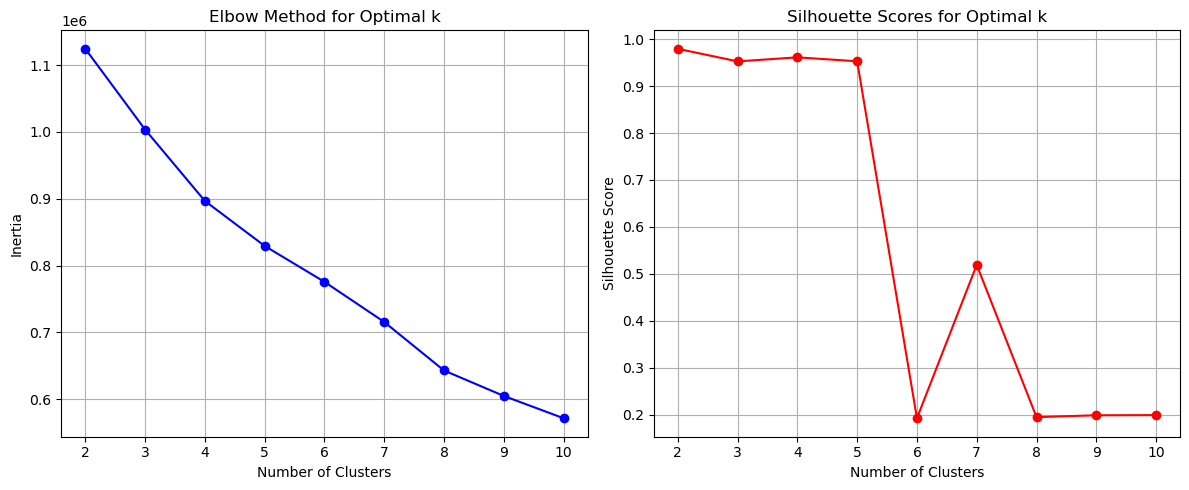

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np

# Determine optimal number of clusters using the Elbow Method
def find_optimal_clusters(X, max_clusters=10):
    inertia = []
    silhouette_scores = []
    k_range = range(2, max_clusters+1)
    
    for k in k_range:
        # KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
        # Silhouette score (only valid for k >= 2)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"K={k}, Silhouette Score={score:.4f}")
    
    # Plot Elbow Method
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Optimal k')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return inertia, silhouette_scores

# Run the function
inertia, silhouette_scores = find_optimal_clusters(X_normalized, max_clusters=10)

## Multiple Clustering Algos

In [ ]:
def implement_clustering_algorithms(X, n_clusters):
    results = {}
    
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    results['KMeans'] = {
        'model': kmeans,
        'labels': kmeans_labels,
        'silhouette': kmeans_silhouette
    }
    
    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X)
    hierarchical_silhouette = silhouette_score(X, hierarchical_labels)
    results['Hierarchical'] = {
        'model': hierarchical,
        'labels': hierarchical_labels,
        'silhouette': hierarchical_silhouette
    }
    
    # DBSCAN (eps parameter needs to be tuned for your specific dataset)
    # Start with a reasonable value and adjust based on results
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)
    
    # Calculate silhouette only if more than one cluster is found and no noise points
    if len(np.unique(dbscan_labels)) > 1 and -1 not in dbscan_labels:
        dbscan_silhouette = silhouette_score(X, dbscan_labels)
    else:
        dbscan_silhouette = None
        print("DBSCAN did not form valid clusters for silhouette calculation.")
        print(f"Unique labels: {np.unique(dbscan_labels)}")
        print(f"Noise points: {np.sum(dbscan_labels == -1)}")
    
    results['DBSCAN'] = {
        'model': dbscan,
        'labels': dbscan_labels,
        'silhouette': dbscan_silhouette
    }
    
    # Print results
    print("\nClustering Algorithm Comparison:")
    print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")
    print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.4f}")
    if dbscan_silhouette is not None:
        print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
    
    return results

# Based on the optimal k determined from previous step

optimal_k = 4  # Replace with your optimal value
clustering_results = implement_clustering_algorithms(X_normalized, optimal_k)

DBSCAN did not form valid clusters for silhouette calculation.
Unique labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 2

## Visualizing Clustering Results 

/var/folders/6k/z_5jgpzx3gv7nz188p4vycxr0000gn/T/ipykernel_90853/2155860226.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


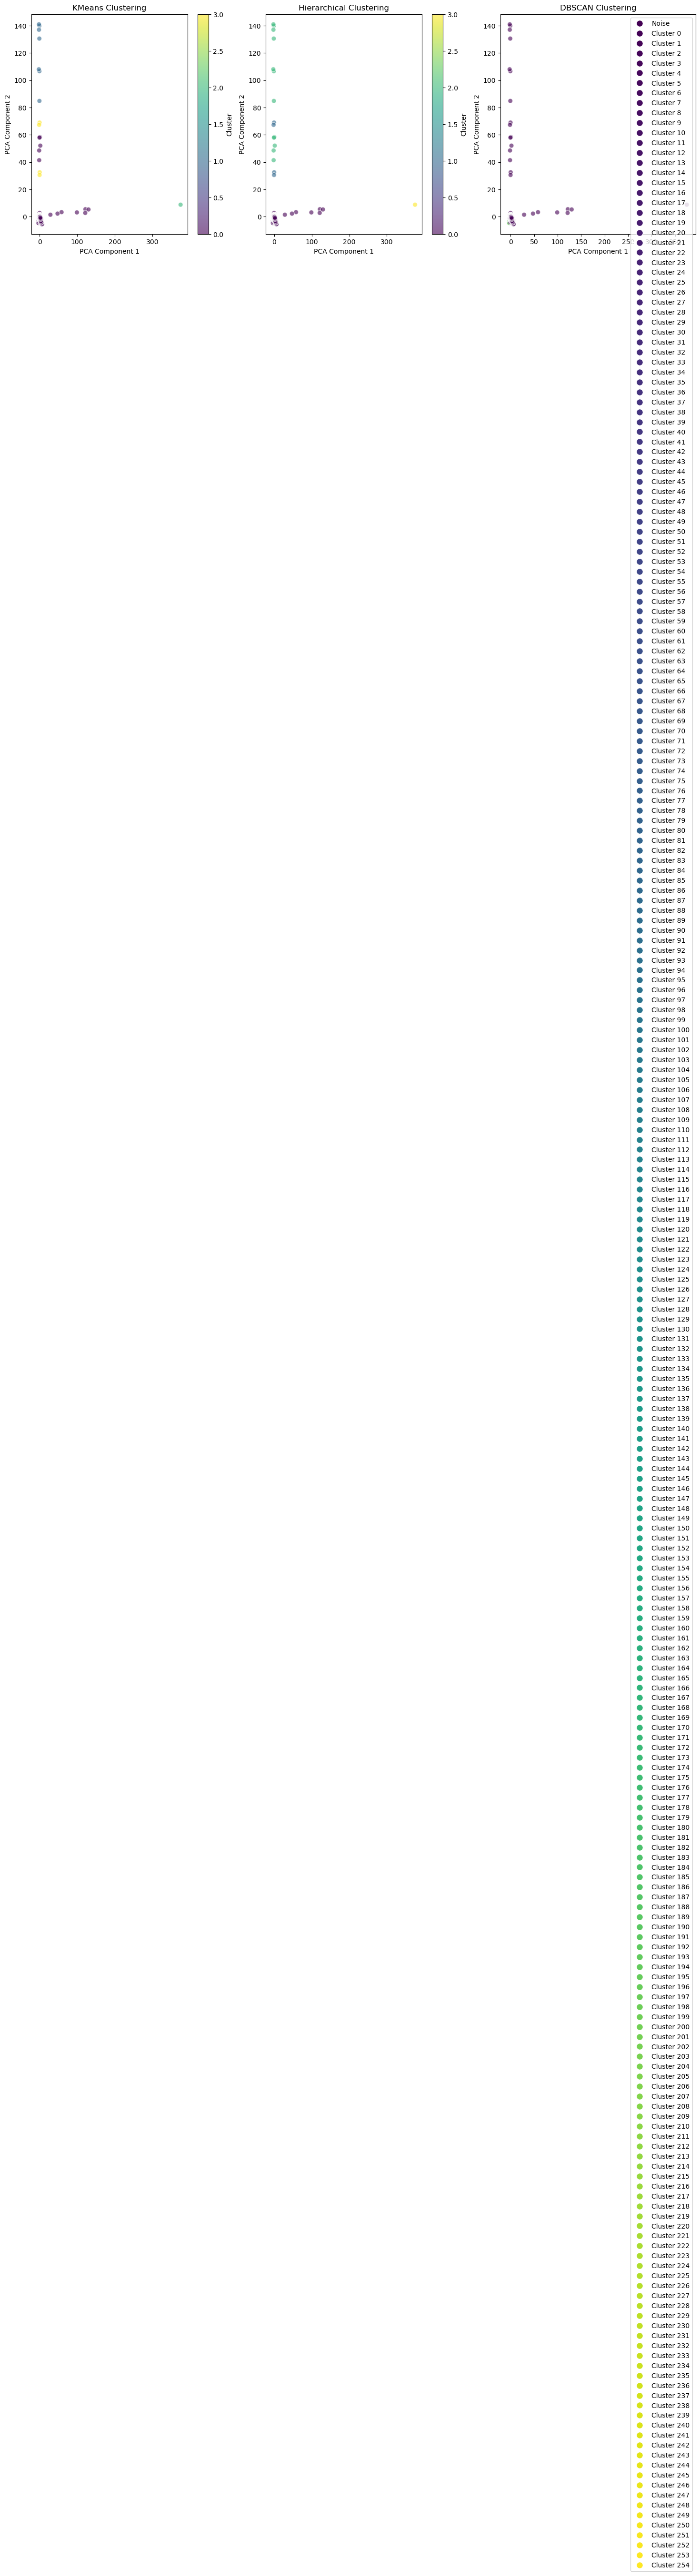

Showing only first 10 features due to large feature set.


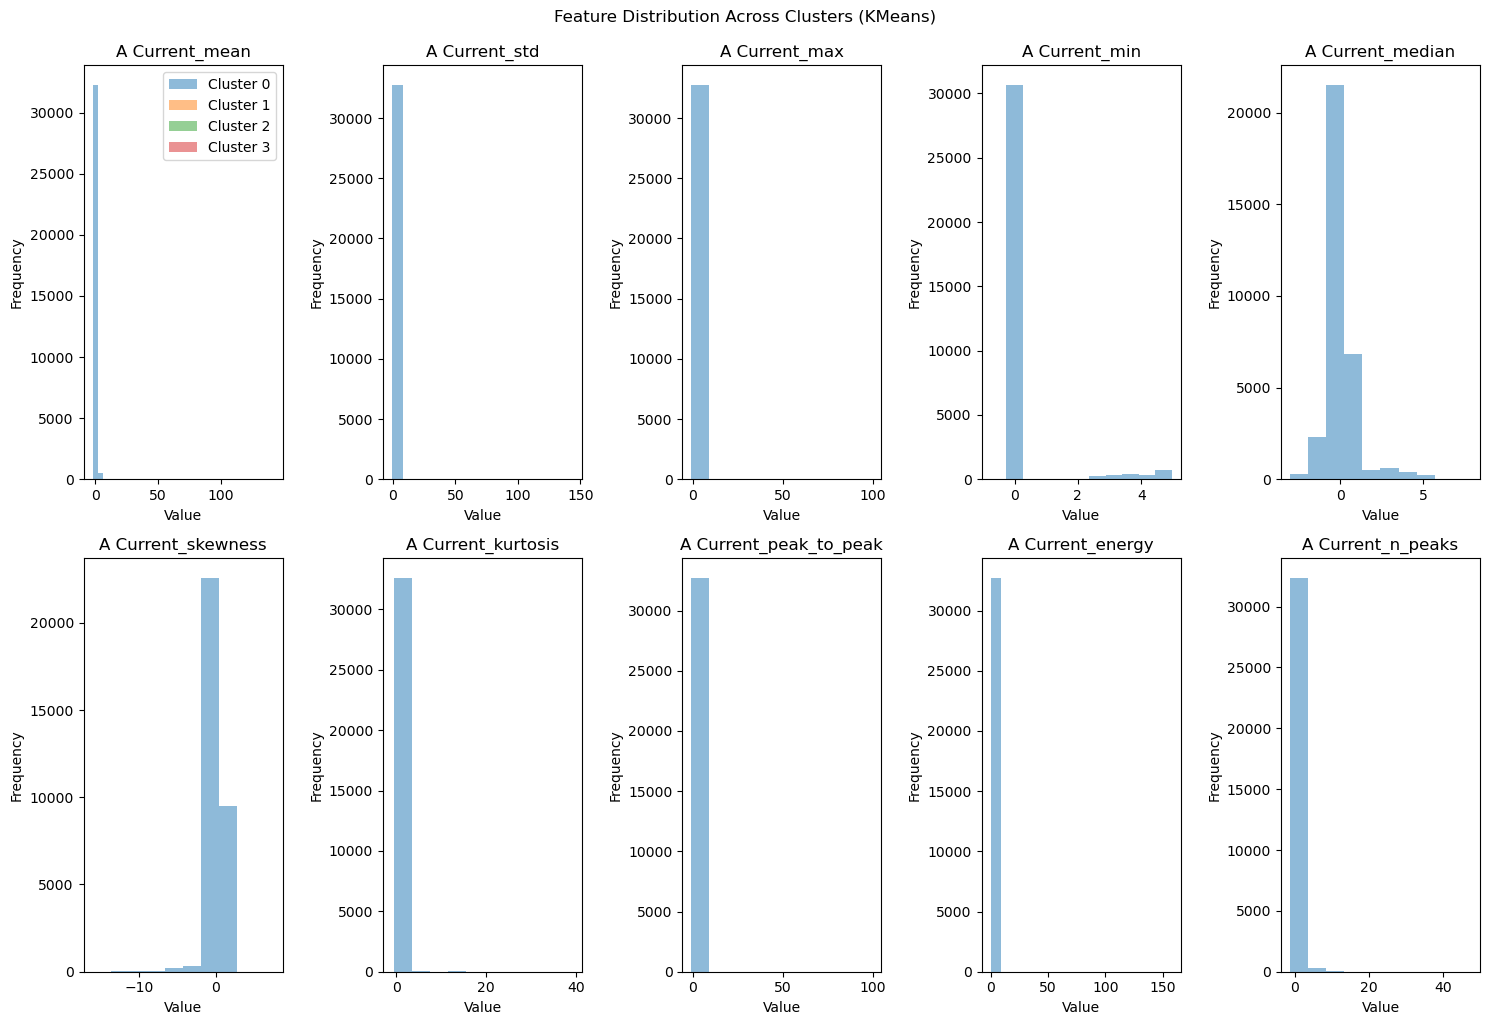

In [21]:
def visualize_clustering(X, results, feature_names=None):
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(18, 6))
    
    # Plot for each clustering algorithm
    algorithms = list(results.keys())
    for i, algo in enumerate(algorithms):
        plt.subplot(1, len(algorithms), i+1)
        
        # Get labels
        labels = results[algo]['labels']
        
        # Create scatter plot with colors based on cluster labels
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', 
                   alpha=0.6, s=50, edgecolors='w')
        
        # Add legend
        unique_labels = np.unique(labels)
        if -1 in unique_labels:  # For DBSCAN with noise points
            handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=scatter.cmap(scatter.norm(label)), 
                                 markersize=10) for label in unique_labels]
            labels_text = [f'Cluster {label}' if label != -1 else 'Noise' for label in unique_labels]
            plt.legend(handles, labels_text)
        else:
            plt.colorbar(label='Cluster')
        
        plt.title(f'{algo} Clustering')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        
    plt.tight_layout()
    plt.show()
    
    # Visualize feature distributions within clusters (only for KMeans for simplicity)
    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(X.shape[1])]
        
    # Select a subset of features for visualization if there are many
    if len(feature_names) > 10:
        selected_features = feature_names[:10]  # First 10 features
        print("Showing only first 10 features due to large feature set.")
    else:
        selected_features = feature_names
    
    # Get KMeans labels
    kmeans_labels = results['KMeans']['labels']
    
    # Create a figure for feature distribution across clusters
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(selected_features):
        plt.subplot(2, 5, i+1)
        for cluster in np.unique(kmeans_labels):
            cluster_data = X[kmeans_labels == cluster, i]
            plt.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}')
        plt.title(feature)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        if i == 0:  # Only add legend to the first subplot
            plt.legend()
    
    plt.tight_layout()
    plt.suptitle('Feature Distribution Across Clusters (KMeans)', y=1.02)
    plt.show()

# Get the original feature names
feature_names = features_df.columns.tolist()

# Visualize the clustering results
visualize_clustering(X_normalized, clustering_results, feature_names)

## Cluster Characteristics

In [22]:
def analyze_clusters(X, results, feature_names):
    # Use KMeans results for the analysis
    kmeans_labels = results['KMeans']['labels']
    
    # Create a DataFrame with features and cluster labels
    df_analysis = pd.DataFrame(X, columns=feature_names)
    df_analysis['Cluster'] = kmeans_labels
    
    # Compute cluster statistics
    cluster_stats = df_analysis.groupby('Cluster').agg(['mean', 'std'])
    
    # Find the most distinguishing features for each cluster
    cluster_means = df_analysis.groupby('Cluster').mean()
    overall_mean = df_analysis.drop('Cluster', axis=1).mean()
    
    # Calculate how much each feature deviates from the overall mean in each cluster
    feature_importance = abs(cluster_means - overall_mean)
    
    # For each cluster, find the top distinguishing features
    top_features = {}
    for cluster in np.unique(kmeans_labels):
        cluster_importance = feature_importance.loc[cluster].sort_values(ascending=False)
        top_features[cluster] = cluster_importance.index[:5].tolist()  # Top 5 features
    
    # Print results
    print("\nCluster Analysis:")
    print(f"Number of samples in each cluster: {df_analysis['Cluster'].value_counts().to_dict()}")
    
    print("\nTop distinguishing features for each cluster:")
    for cluster, features in top_features.items():
        print(f"\nCluster {cluster}:")
        for feature in features:
            deviation = feature_importance.loc[cluster, feature]
            direction = "higher" if cluster_means.loc[cluster, feature] > overall_mean[feature] else "lower"
            print(f"  - {feature}: {deviation:.4f} ({direction} than average)")
    
    return cluster_stats, top_features

# Run the analysis
cluster_stats, top_features = analyze_clusters(X_normalized, clustering_results, feature_names)


Cluster Analysis:
Number of samples in each cluster: {0: 32743, 1: 7, 3: 4, 2: 1}

Top distinguishing features for each cluster:

Cluster 0:
  - A Voltage_energy: 0.0139 (lower than average)
  - A Voltage_std: 0.0136 (lower than average)
  - A Voltage_mean: 0.0118 (lower than average)
  - A Voltage_peak_to_peak: 0.0114 (lower than average)
  - A Voltage_max: 0.0114 (lower than average)

Cluster 1:
  - A Voltage_energy: 64.8415 (higher than average)
  - A Voltage_std: 63.5829 (higher than average)
  - A Voltage_mean: 55.4483 (higher than average)
  - A Voltage_max: 53.4713 (higher than average)
  - A Voltage_peak_to_peak: 53.4713 (higher than average)

Cluster 2:
  - A Current_energy: 157.2872 (higher than average)
  - B Current_energy: 148.0180 (higher than average)
  - A Current_std: 143.6429 (higher than average)
  - A Current_mean: 141.8930 (higher than average)
  - B Current_mean: 131.3486 (higher than average)

Cluster 3:
  - B Voltage_max: 89.3317 (higher than average)
  - B Vol

In [23]:
def evaluate_clustering_stability(X, n_clusters, n_iterations=10):
    from sklearn.metrics import adjusted_rand_score
    
    # Run KMeans multiple times with different initializations
    base_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    base_labels = base_kmeans.fit_predict(X)
    
    stability_scores = []
    
    for i in range(n_iterations):
        # Run with different random state
        kmeans = KMeans(n_clusters=n_clusters, random_state=i, n_init=10)
        new_labels = kmeans.fit_predict(X)
        
        # Compare with base labels using Adjusted Rand Index
        ari_score = adjusted_rand_score(base_labels, new_labels)
        stability_scores.append(ari_score)
    
    avg_stability = np.mean(stability_scores)
    std_stability = np.std(stability_scores)
    
    print(f"\nClustering Stability Analysis (over {n_iterations} iterations):")
    print(f"Average Adjusted Rand Index: {avg_stability:.4f}")
    print(f"Standard Deviation: {std_stability:.4f}")
    
    return avg_stability, std_stability

# Evaluate the stability of KMeans clustering
stability_avg, stability_std = evaluate_clustering_stability(X_normalized, optimal_k)


Clustering Stability Analysis (over 10 iterations):
Average Adjusted Rand Index: 0.5278
Standard Deviation: 0.4292


In [25]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, PowerTransformer

# Tring different scaling approaches
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),  # Less sensitive to outliers
    'MinMaxScaler': MinMaxScaler(),
}

# Compare different scalers
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(features_df)
    
    # Run KMeans with this scaling
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Count samples in each cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_distribution = dict(zip(unique, counts))
    
    print(f"\n{scaler_name} results:")
    print(f"Cluster distribution: {cluster_distribution}")
    
    # Calculate silhouette score if there's more than one cluster with data
    if len(unique) > 1:
        score = silhouette_score(X_scaled, labels)
        print(f"Silhouette score: {score:.4f}")


StandardScaler results:
Cluster distribution: {0: 32743, 1: 7, 2: 1, 3: 4}
Silhouette score: 0.9614

RobustScaler results:
Cluster distribution: {0: 32752, 1: 1, 2: 1, 3: 1}
Silhouette score: 0.9992

MinMaxScaler results:
Cluster distribution: {0: 24056, 1: 2067, 2: 2096, 3: 4536}
Silhouette score: 0.5116


## Going Ahead with Minmaxscaler 

In [26]:
# Use MinMaxScaler for better cluster distribution
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features_df)

# Run KMeans with this scaling
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original features dataframe
features_df['cluster'] = labels

# Analyze clusters
def analyze_improved_clusters(df, feature_names):
    # Compute cluster statistics
    cluster_stats = df.groupby('cluster').agg(['mean', 'std'])
    
    # Find the most distinguishing features for each cluster
    cluster_means = df.groupby('cluster').mean()
    overall_mean = df.drop('cluster', axis=1).mean()
    
    # Calculate how much each feature deviates from the overall mean in each cluster
    feature_importance = abs(cluster_means - overall_mean)
    
    # For each cluster, find the top distinguishing features
    top_features = {}
    for cluster in np.unique(df['cluster']):
        cluster_importance = feature_importance.loc[cluster].sort_values(ascending=False)
        top_features[cluster] = cluster_importance.index[:5].tolist()  # Top 5 features
    
    # Print results
    print("\nImproved Cluster Analysis:")
    print(f"Number of samples in each cluster: {df['cluster'].value_counts().to_dict()}")
    
    print("\nTop distinguishing features for each cluster:")
    for cluster, features in top_features.items():
        print(f"\nCluster {cluster}:")
        for feature in features:
            deviation = feature_importance.loc[cluster, feature]
            direction = "higher" if cluster_means.loc[cluster, feature] > overall_mean[feature] else "lower"
            print(f"  - {feature}: {deviation:.4f} ({direction} than average)")
    
    return cluster_stats, top_features

# Run the improved analysis
improved_cluster_stats, improved_top_features = analyze_improved_clusters(features_df, features_df.columns[:-1])


Improved Cluster Analysis:
Number of samples in each cluster: {0: 24056, 3: 4536, 2: 2096, 1: 2067}

Top distinguishing features for each cluster:

Cluster 0:
  - A Voltage_energy: 399470.1955 (lower than average)
  - B Voltage_energy: 92793.2493 (lower than average)
  - A Current_energy: 587.0764 (lower than average)
  - B Current_energy: 453.7772 (lower than average)
  - A Voltage_median: 5.2790 (higher than average)

Cluster 1:
  - A Voltage_energy: 723434.6032 (higher than average)
  - B Voltage_energy: 325149.7097 (higher than average)
  - A Current_energy: 148.1051 (higher than average)
  - B Current_energy: 43.5081 (lower than average)
  - A Voltage_n_peaks: 13.0682 (higher than average)

Cluster 2:
  - A Voltage_energy: 2598720.9450 (higher than average)
  - B Voltage_energy: 862254.9007 (higher than average)
  - A Current_energy: 515.8429 (lower than average)
  - B Current_energy: 171.2127 (higher than average)
  - B Voltage_n_peaks: 10.3748 (higher than average)

Cluster 3:


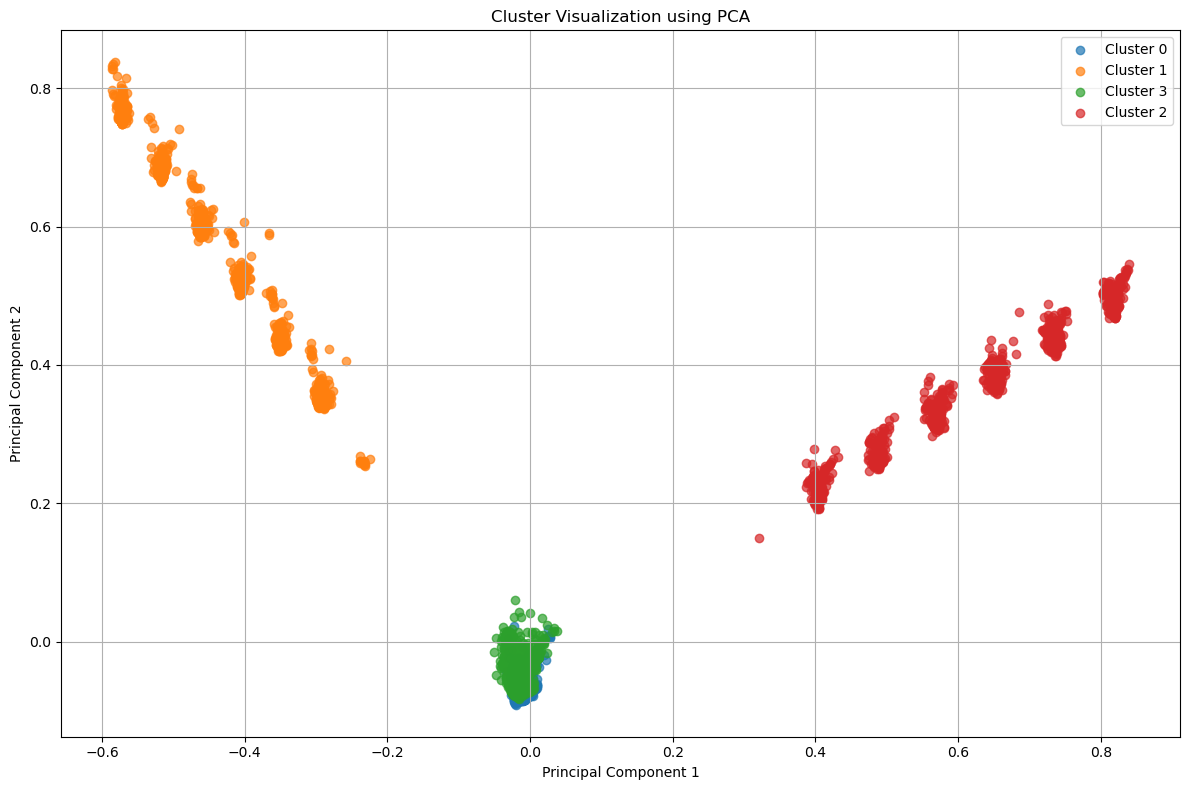

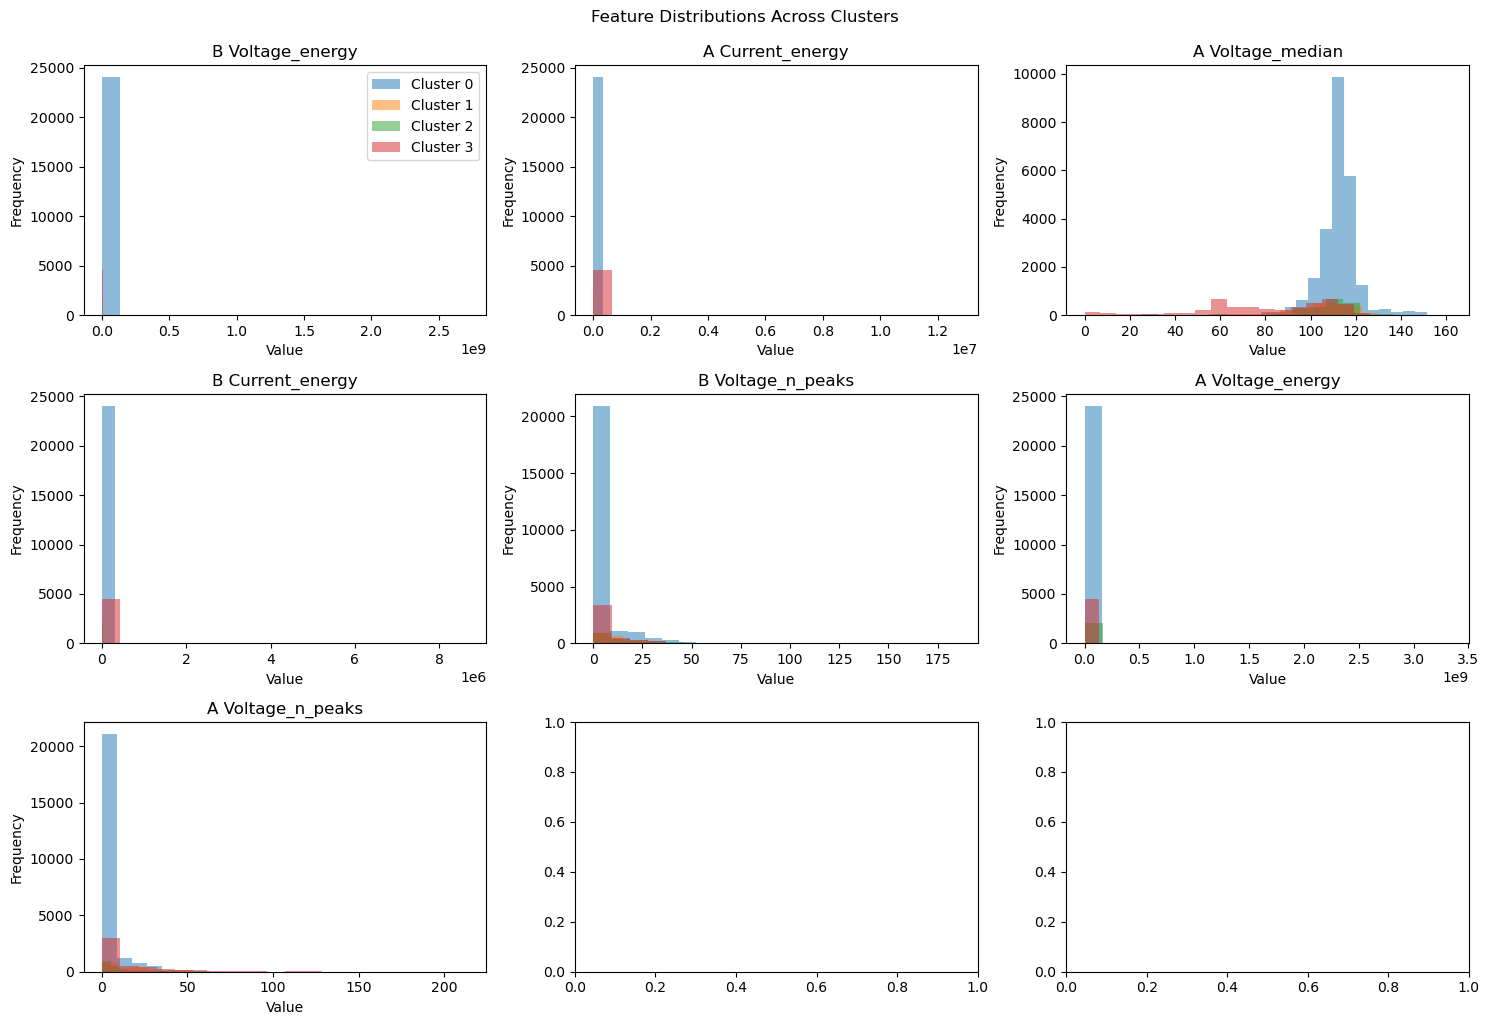

In [27]:
# Visualize clusters using PCA
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels

# Plot the clusters
plt.figure(figsize=(12, 8))
for cluster in pca_df['cluster'].unique():
    subset = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('Cluster Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot feature distributions by cluster for top distinguishing features
top_features_all = set()
for features in improved_top_features.values():
    top_features_all.update(features)

# Create a figure with subplots for each top feature
n_features = len(top_features_all)
fig, axes = plt.subplots(nrows=min(3, n_features), ncols=min(3, (n_features+2)//3), 
                         figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(list(top_features_all)[:min(9, n_features)]):
    for cluster in np.unique(labels):
        cluster_data = features_df[features_df['cluster'] == cluster][feature]
        axes[i].hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}', bins=20)
    
    axes[i].set_title(feature)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    if i == 0:  # Only add legend to the first subplot
        axes[i].legend()

plt.tight_layout()
plt.suptitle('Feature Distributions Across Clusters', y=1.02)
plt.show()

In [28]:
# Display samples from each cluster
print("\nSample data from each cluster:")
for cluster in np.unique(labels):
    print(f"\nCluster {cluster} (sample of 3 records):")
    print(features_df[features_df['cluster'] == cluster].iloc[:3, :-1])  # Exclude the cluster column


Sample data from each cluster:

Cluster 0 (sample of 3 records):
   A Current_mean  A Current_std  A Current_max  A Current_min  \
0        2.521875       0.936327            4.7            0.0   
1        2.375000       0.949671            5.0            0.0   
2        2.334483       0.787084            4.4            0.0   

   A Current_median  A Current_skewness  A Current_kurtosis  \
0               2.6           -0.164396            1.326967   
1               2.4            0.018936            1.415136   
2               2.2           -0.128263            1.767981   

   A Current_peak_to_peak  A Current_energy  A Current_n_peaks  ...  \
0                     4.7            231.57                2.0  ...   
1                     5.0            209.36                2.0  ...   
2                     4.4            176.01                2.0  ...   

   B Voltage_mean  B Voltage_std  B Voltage_max  B Voltage_min  \
0       90.629032      26.022003          108.0            0.0   

In [29]:
# Check for stability across different random initializations
from sklearn.metrics import adjusted_rand_score

base_labels = labels.copy()
stability_scores = []

for i in range(10):
    # Run with different random state
    kmeans_test = KMeans(n_clusters=4, random_state=i, n_init=10)
    new_labels = kmeans_test.fit_predict(X_scaled)
    
    # Compare with base labels using Adjusted Rand Index
    ari_score = adjusted_rand_score(base_labels, new_labels)
    stability_scores.append(ari_score)

print(f"\nClustering Stability Analysis:")
print(f"Average Adjusted Rand Index: {np.mean(stability_scores):.4f}")
print(f"Standard Deviation: {np.std(stability_scores):.4f}")


Clustering Stability Analysis:
Average Adjusted Rand Index: 0.9999
Standard Deviation: 0.0001


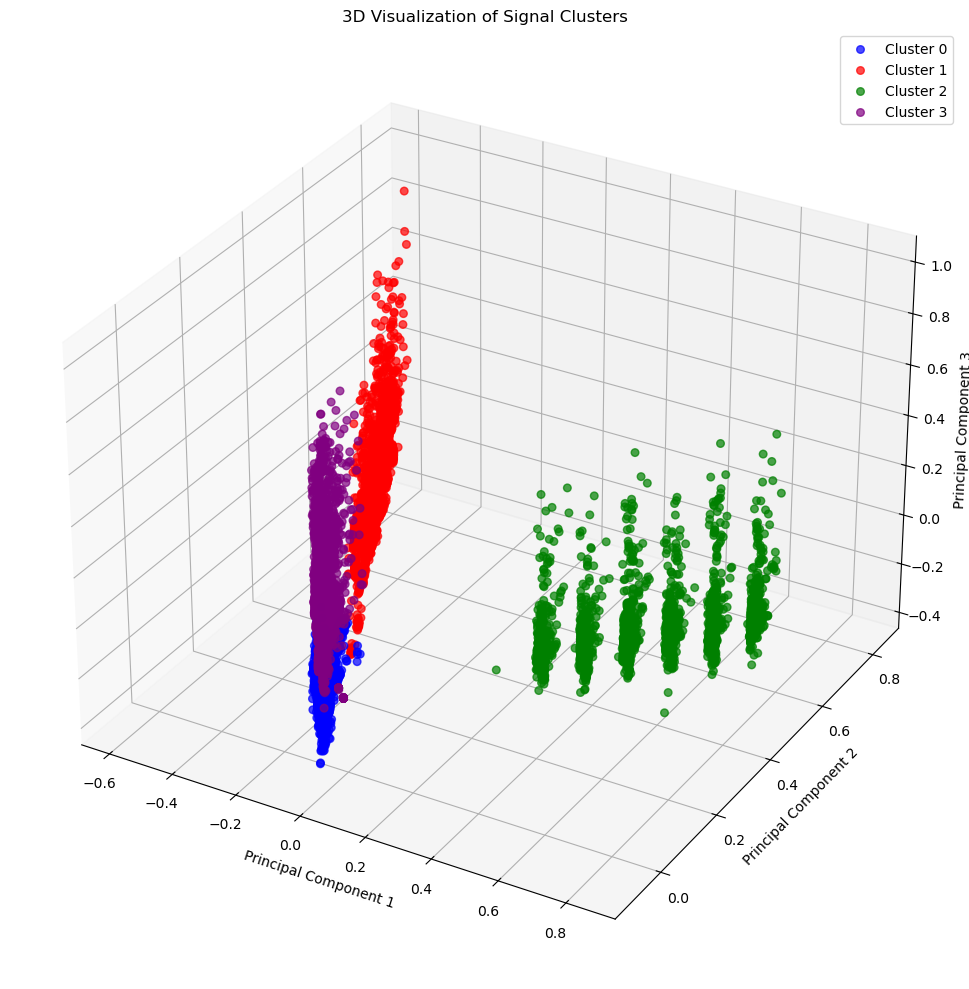

Explained variance by PCA components:
PC1: 0.2874
PC2: 0.2526
PC3: 0.1294
Total: 0.6693


In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Apply PCA with 3 components for 3D visualization
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

# Create a DataFrame for easier plotting
pca_3d_df = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['cluster'] = labels

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define colors for clusters
colors = ['blue', 'red', 'green', 'purple']

# Plot each cluster
for i, cluster in enumerate(sorted(pca_3d_df['cluster'].unique())):
    subset = pca_3d_df[pca_3d_df['cluster'] == cluster]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], 
               label=f'Cluster {cluster}', color=colors[i], 
               alpha=0.7, s=30)

# Add labels and legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Signal Clusters')
ax.legend()

plt.tight_layout()
plt.show()

# Print explained variance by each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components:")
print(f"PC1: {explained_variance[0]:.4f}")
print(f"PC2: {explained_variance[1]:.4f}")
print(f"PC3: {explained_variance[2]:.4f}")
print(f"Total: {sum(explained_variance):.4f}")

### Detailed cluster characterization

In [31]:

def characterize_clusters(df, cluster_column='cluster'):
    # Add original (non-scaled) data for better interpretation
    cluster_stats = df.groupby(cluster_column).agg(['mean', 'median', 'std', 'min', 'max'])
    
    print("\n=== DETAILED CLUSTER CHARACTERIZATION ===")
    
    # For each cluster
    for cluster in sorted(df[cluster_column].unique()):
        cluster_data = df[df[cluster_column] == cluster]
        cluster_size = len(cluster_data)
        total_size = len(df)
        
        print(f"\n\nCLUSTER {cluster} ANALYSIS")
        print(f"Size: {cluster_size} samples ({cluster_size/total_size*100:.2f}% of total)")
        
        # Calculate z-scores for features to identify most distinctive ones
        all_means = df.drop(cluster_column, axis=1).mean()
        all_stds = df.drop(cluster_column, axis=1).std()
        cluster_means = cluster_data.drop(cluster_column, axis=1).mean()
        
        # Calculate how many standard deviations away from overall mean
        z_scores = (cluster_means - all_means) / all_stds
        
        # Sort features by absolute z-score
        distinctive_features = z_scores.abs().sort_values(ascending=False)
        
        print("\nMOST DISTINCTIVE FEATURES:")
        for feature in distinctive_features.index[:10]:  # Top 10 features
            direction = "HIGHER" if z_scores[feature] > 0 else "LOWER"
            print(f"• {feature}: {z_scores[feature]:.2f} std. dev. {direction} than average")
            print(f"  - Cluster mean: {cluster_means[feature]:.4f}")
            print(f"  - Overall mean: {all_means[feature]:.4f}")
        
        # Identify features with low variance within cluster (consistent patterns)
        cluster_var = cluster_data.drop(cluster_column, axis=1).var()
        all_var = df.drop(cluster_column, axis=1).var()
        var_ratio = cluster_var / all_var
        
        consistent_features = var_ratio.sort_values().head(5)
        print("\nMOST CONSISTENT FEATURES (Low within-cluster variance):")
        for feature in consistent_features.index:
            print(f"• {feature}: {var_ratio[feature]:.4f} times the overall variance")
    
    return cluster_stats

# Run the detailed characterization
detailed_stats = characterize_clusters(features_df)


=== DETAILED CLUSTER CHARACTERIZATION ===


CLUSTER 0 ANALYSIS
Size: 24056 samples (73.44% of total)

MOST DISTINCTIVE FEATURES:
• A Voltage_median: 0.29 std. dev. HIGHER than average
  - Cluster mean: 111.7461
  - Overall mean: 106.4671
• A Current_min: -0.26 std. dev. LOWER than average
  - Cluster mean: 0.0000
  - Overall mean: 0.0490
• B Current_min: -0.25 std. dev. LOWER than average
  - Cluster mean: 0.0000
  - Overall mean: 0.0473
• B Current_median: -0.21 std. dev. LOWER than average
  - Cluster mean: 2.3208
  - Overall mean: 2.4978
• A Current_median: -0.19 std. dev. LOWER than average
  - Cluster mean: 2.3677
  - Overall mean: 2.5261
• A Voltage_n_peaks: -0.19 std. dev. LOWER than average
  - Cluster mean: 4.7590
  - Overall mean: 7.4113
• B Voltage_skewness: 0.15 std. dev. HIGHER than average
  - Cluster mean: -1.9630
  - Overall mean: -2.1799
• B Voltage_n_peaks: -0.14 std. dev. LOWER than average
  - Cluster mean: 5.1205
  - Overall mean: 6.8623
• B Voltage_kurtosis: -0.1

In [43]:
import seaborn as sns 

def analyze_site_distribution(df, site_column='Site', cluster_column='cluster'):
    # Check if Site column exists in the dataframe
    if site_column not in df.columns:
        print(f"'{site_column}' column not found in the dataframe. Please add site information.")
        return None
    
    # Calculate overall site distribution
    overall_site_counts = df[site_column].value_counts()
    overall_site_percentages = df[site_column].value_counts(normalize=True) * 100
    
    print("\n=== SITE DISTRIBUTION ANALYSIS ===")
    print("\nOVERALL SITE DISTRIBUTION:")
    for site, count in overall_site_counts.items():
        print(f"{site}: {count} samples ({overall_site_percentages[site]:.2f}%)")
    
    # Analyze site distribution within each cluster
    for cluster in sorted(df[cluster_column].unique()):
        cluster_data = df[df[cluster_column] == cluster]
        cluster_site_counts = cluster_data[site_column].value_counts()
        cluster_site_percentages = cluster_data[site_column].value_counts(normalize=True) * 100
        
        print(f"\nCLUSTER {cluster} SITE DISTRIBUTION:")
        for site in cluster_site_counts.index:
            site_enrichment = (cluster_site_percentages[site] / overall_site_percentages[site]) if site in overall_site_percentages else float('inf')
            print(f"{site}: {cluster_site_counts[site]} samples ({cluster_site_percentages[site]:.2f}%)")
            print(f"  - Enrichment factor: {site_enrichment:.2f}x")
            
    # Create a heatmap of site vs cluster
    site_cluster_counts = pd.crosstab(df[site_column], df[cluster_column])
    site_cluster_percentages = site_cluster_counts.div(site_cluster_counts.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(site_cluster_percentages, annot=True, cmap="YlGnBu", fmt=".1f")
    plt.title('Percentage of Each Site in Different Clusters')
    plt.ylabel('Site')
    plt.xlabel('Cluster')
    plt.tight_layout()
    plt.show()
    
    return site_cluster_percentages



In [40]:
features_df['Site'] = data['Site Name']

In [41]:
features_df.columns

Index(['A Current_mean', 'A Current_std', 'A Current_max', 'A Current_min',
       'A Current_median', 'A Current_skewness', 'A Current_kurtosis',
       'A Current_peak_to_peak', 'A Current_energy', 'A Current_n_peaks',
       'A Voltage_mean', 'A Voltage_std', 'A Voltage_max', 'A Voltage_min',
       'A Voltage_median', 'A Voltage_skewness', 'A Voltage_kurtosis',
       'A Voltage_peak_to_peak', 'A Voltage_energy', 'A Voltage_n_peaks',
       'B Current_mean', 'B Current_std', 'B Current_max', 'B Current_min',
       'B Current_median', 'B Current_skewness', 'B Current_kurtosis',
       'B Current_peak_to_peak', 'B Current_energy', 'B Current_n_peaks',
       'B Voltage_mean', 'B Voltage_std', 'B Voltage_max', 'B Voltage_min',
       'B Voltage_median', 'B Voltage_skewness', 'B Voltage_kurtosis',
       'B Voltage_peak_to_peak', 'B Voltage_energy', 'B Voltage_n_peaks',
       'cluster', 'Site'],
      dtype='object')


=== SITE DISTRIBUTION ANALYSIS ===

OVERALL SITE DISTRIBUTION:
Dahanu Road: 13561 samples (41.40%)
Bhestan: 5658 samples (17.27%)
Bilimora: 3672 samples (11.21%)
Karambeli: 2165 samples (6.61%)
Vapi: 2020 samples (6.17%)
Gholvad: 1724 samples (5.26%)
Shaphale: 1519 samples (4.64%)
Atul: 1463 samples (4.47%)
Vaitarna: 532 samples (1.62%)
Pardi: 357 samples (1.09%)
Surat: 84 samples (0.26%)

CLUSTER 0 SITE DISTRIBUTION:
Dahanu Road: 12427 samples (51.66%)
  - Enrichment factor: 1.25x
Bhestan: 3588 samples (14.92%)
  - Enrichment factor: 0.86x
Bilimora: 3284 samples (13.65%)
  - Enrichment factor: 1.22x
Vapi: 1235 samples (5.13%)
  - Enrichment factor: 0.83x
Atul: 1163 samples (4.83%)
  - Enrichment factor: 1.08x
Karambeli: 900 samples (3.74%)
  - Enrichment factor: 0.57x
Gholvad: 674 samples (2.80%)
  - Enrichment factor: 0.53x
Shaphale: 472 samples (1.96%)
  - Enrichment factor: 0.42x
Pardi: 175 samples (0.73%)
  - Enrichment factor: 0.67x
Vaitarna: 115 samples (0.48%)
  - Enrichment f

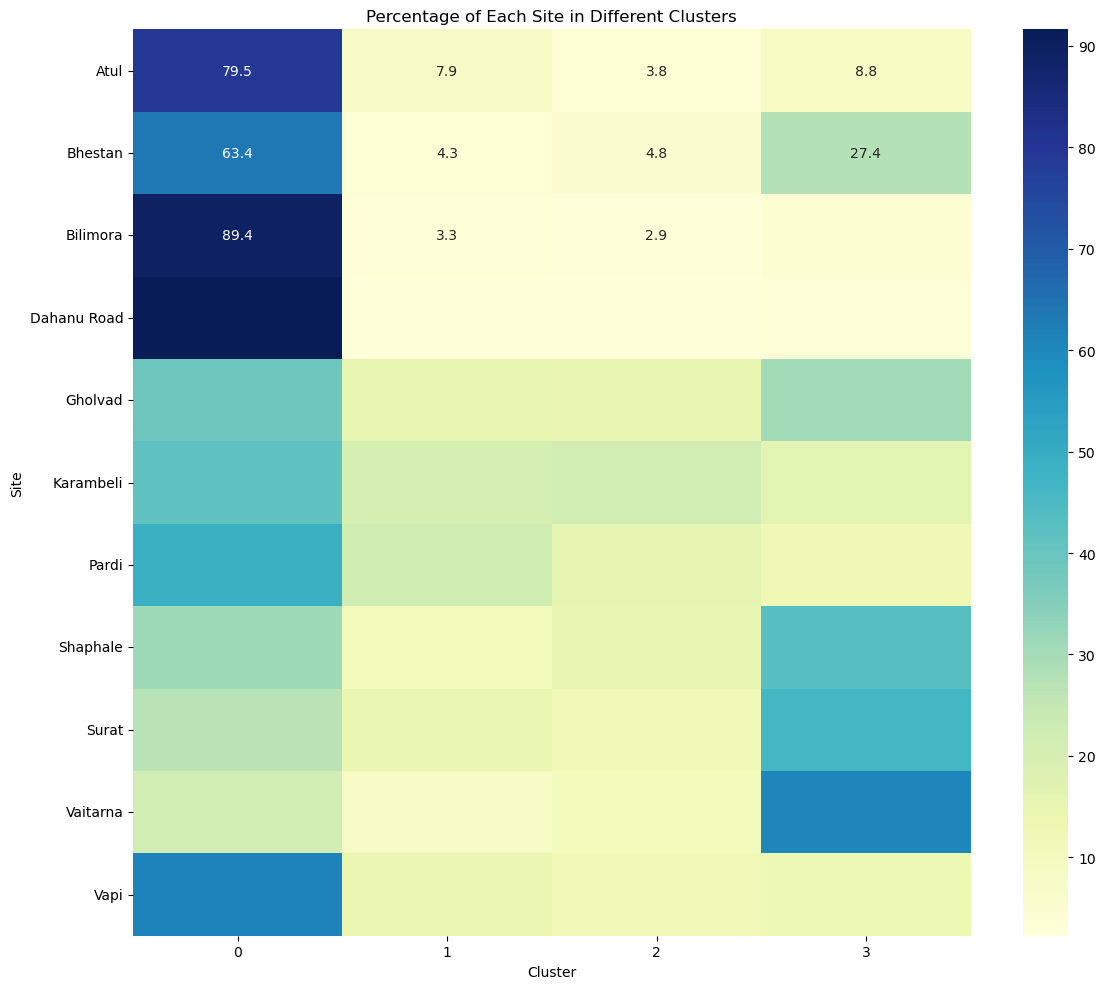

In [44]:
site_distribution = analyze_site_distribution(features_df)

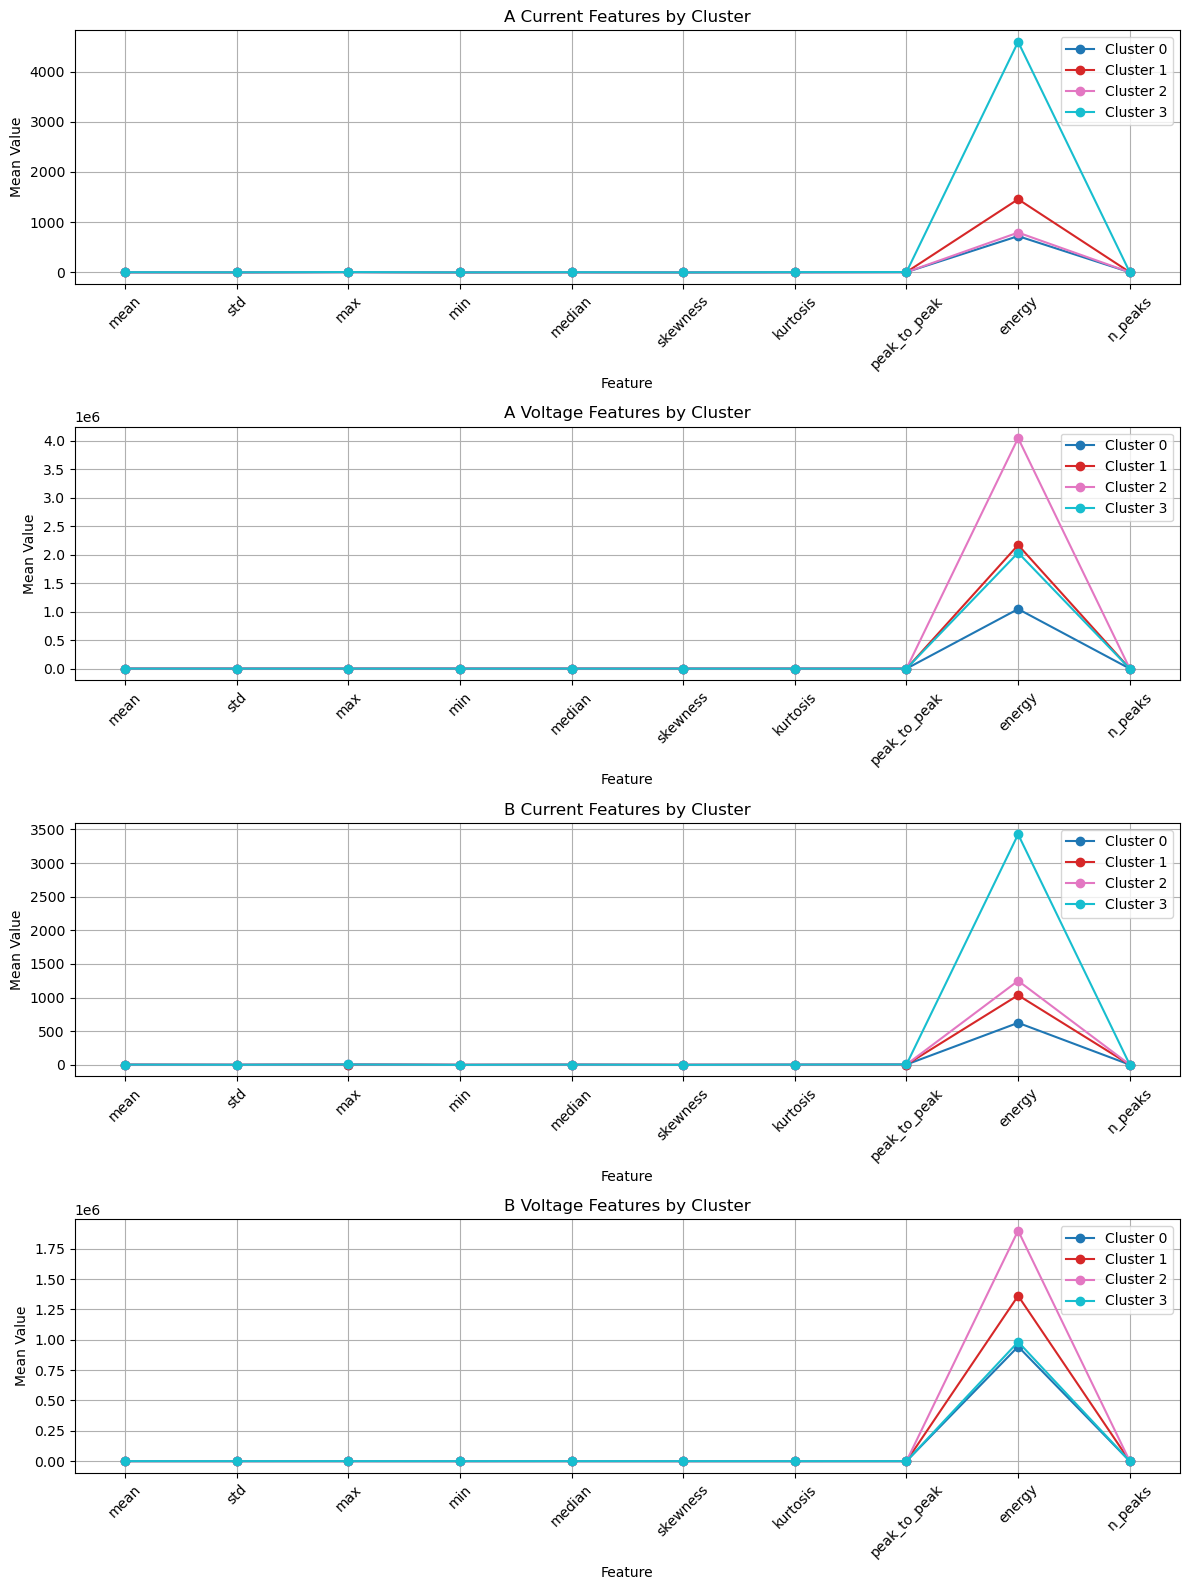

In [45]:
# Create a function to visualize signal patterns for each cluster
def visualize_signal_patterns(df, signal_cols, cluster_column='cluster'):
    n_clusters = len(df[cluster_column].unique())
    n_signals = len(signal_cols)
    
    # Set up the plot
    fig, axes = plt.subplots(n_signals, 1, figsize=(12, 4*n_signals))
    if n_signals == 1:
        axes = [axes]  # Make sure axes is iterable even with one subplot
    
    # Define colors for clusters
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    # For each signal column
    for i, col in enumerate(signal_cols):
        # Plot average pattern for each cluster
        for j, cluster in enumerate(sorted(df[cluster_column].unique())):
            cluster_data = df[df[cluster_column] == cluster]
            
            # Get mean feature values for this signal type
            signal_features = [f for f in df.columns if f.startswith(col)]
            cluster_means = cluster_data[signal_features].mean()
            
            # Plot feature means as a pattern
            axes[i].plot(range(len(signal_features)), cluster_means, 
                        marker='o', linestyle='-', color=colors[j], 
                        label=f'Cluster {cluster}')
        
        # Add labels and legend
        axes[i].set_title(f'{col} Features by Cluster')
        axes[i].set_xlabel('Feature')
        axes[i].set_xticks(range(len(signal_features)))
        axes[i].set_xticklabels([f.replace(f'{col}_', '') for f in signal_features], rotation=45)
        axes[i].set_ylabel('Mean Value')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get the base signal column names (without the specific feature part)
signal_base_cols = ['A Current', 'A Voltage', 'B Current', 'B Voltage']
visualize_signal_patterns(features_df, signal_base_cols)